In [25]:
from model.carvana_unet import load_UNet
import torch

device = 'cpu'
model = load_UNet("../inference/param/unet.pth", device)

In [26]:
from PIL import Image
import torchvision.transforms.functional as TF

img_path = '../dataset/carvana_unet/train_inputs/input_5.jpg'

with Image.open(img_path) as im:
    img = TF.pil_to_tensor(im).float().to(device) / 255

mask_pred = torch.sigmoid(model(img.unsqueeze(0)))

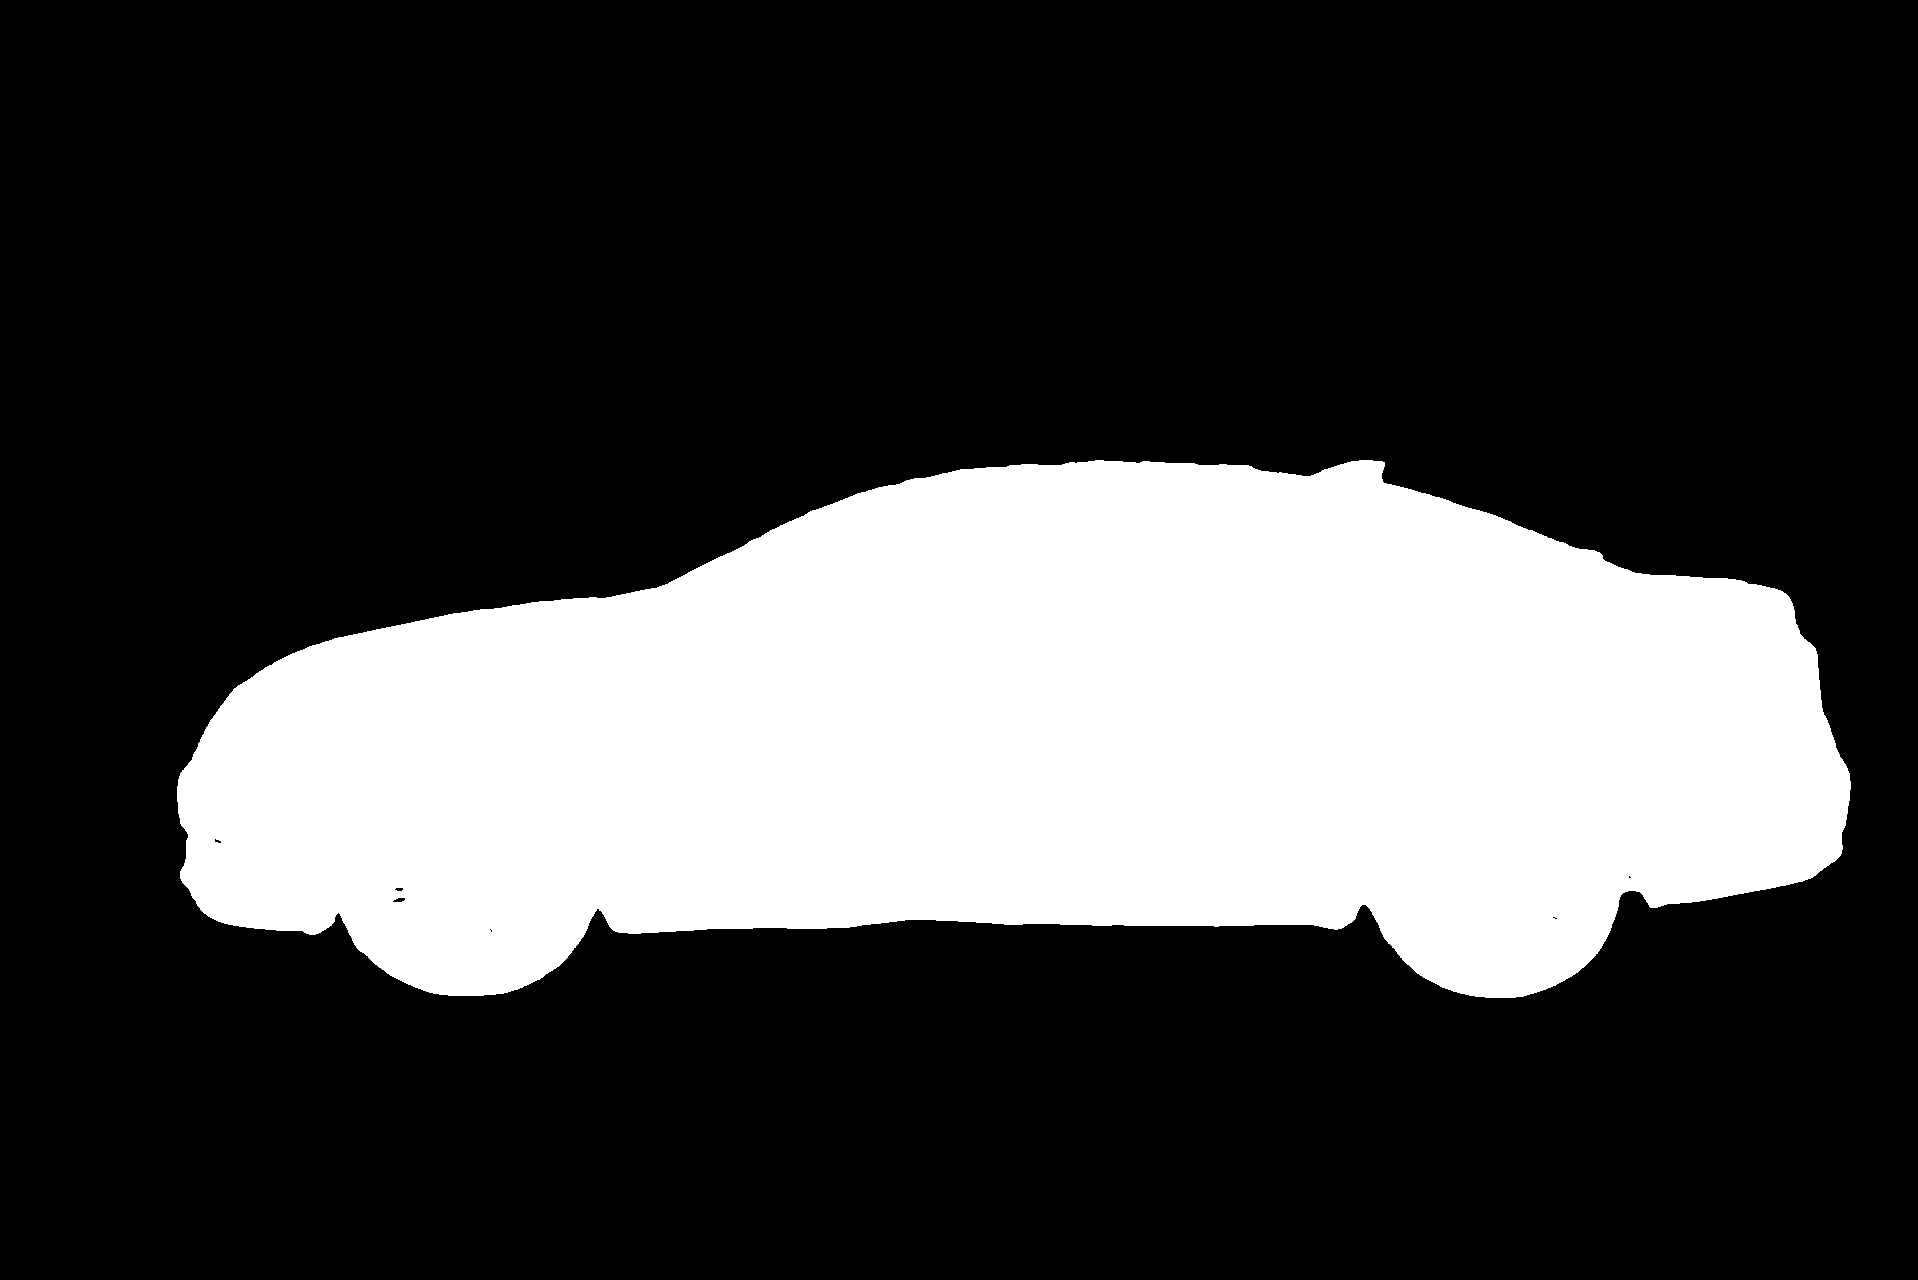

In [29]:
mask_pred = (mask_pred > 0.5).float()
mask_img = TF.to_pil_image(mask_pred.squeeze(0).cpu())
mask_img

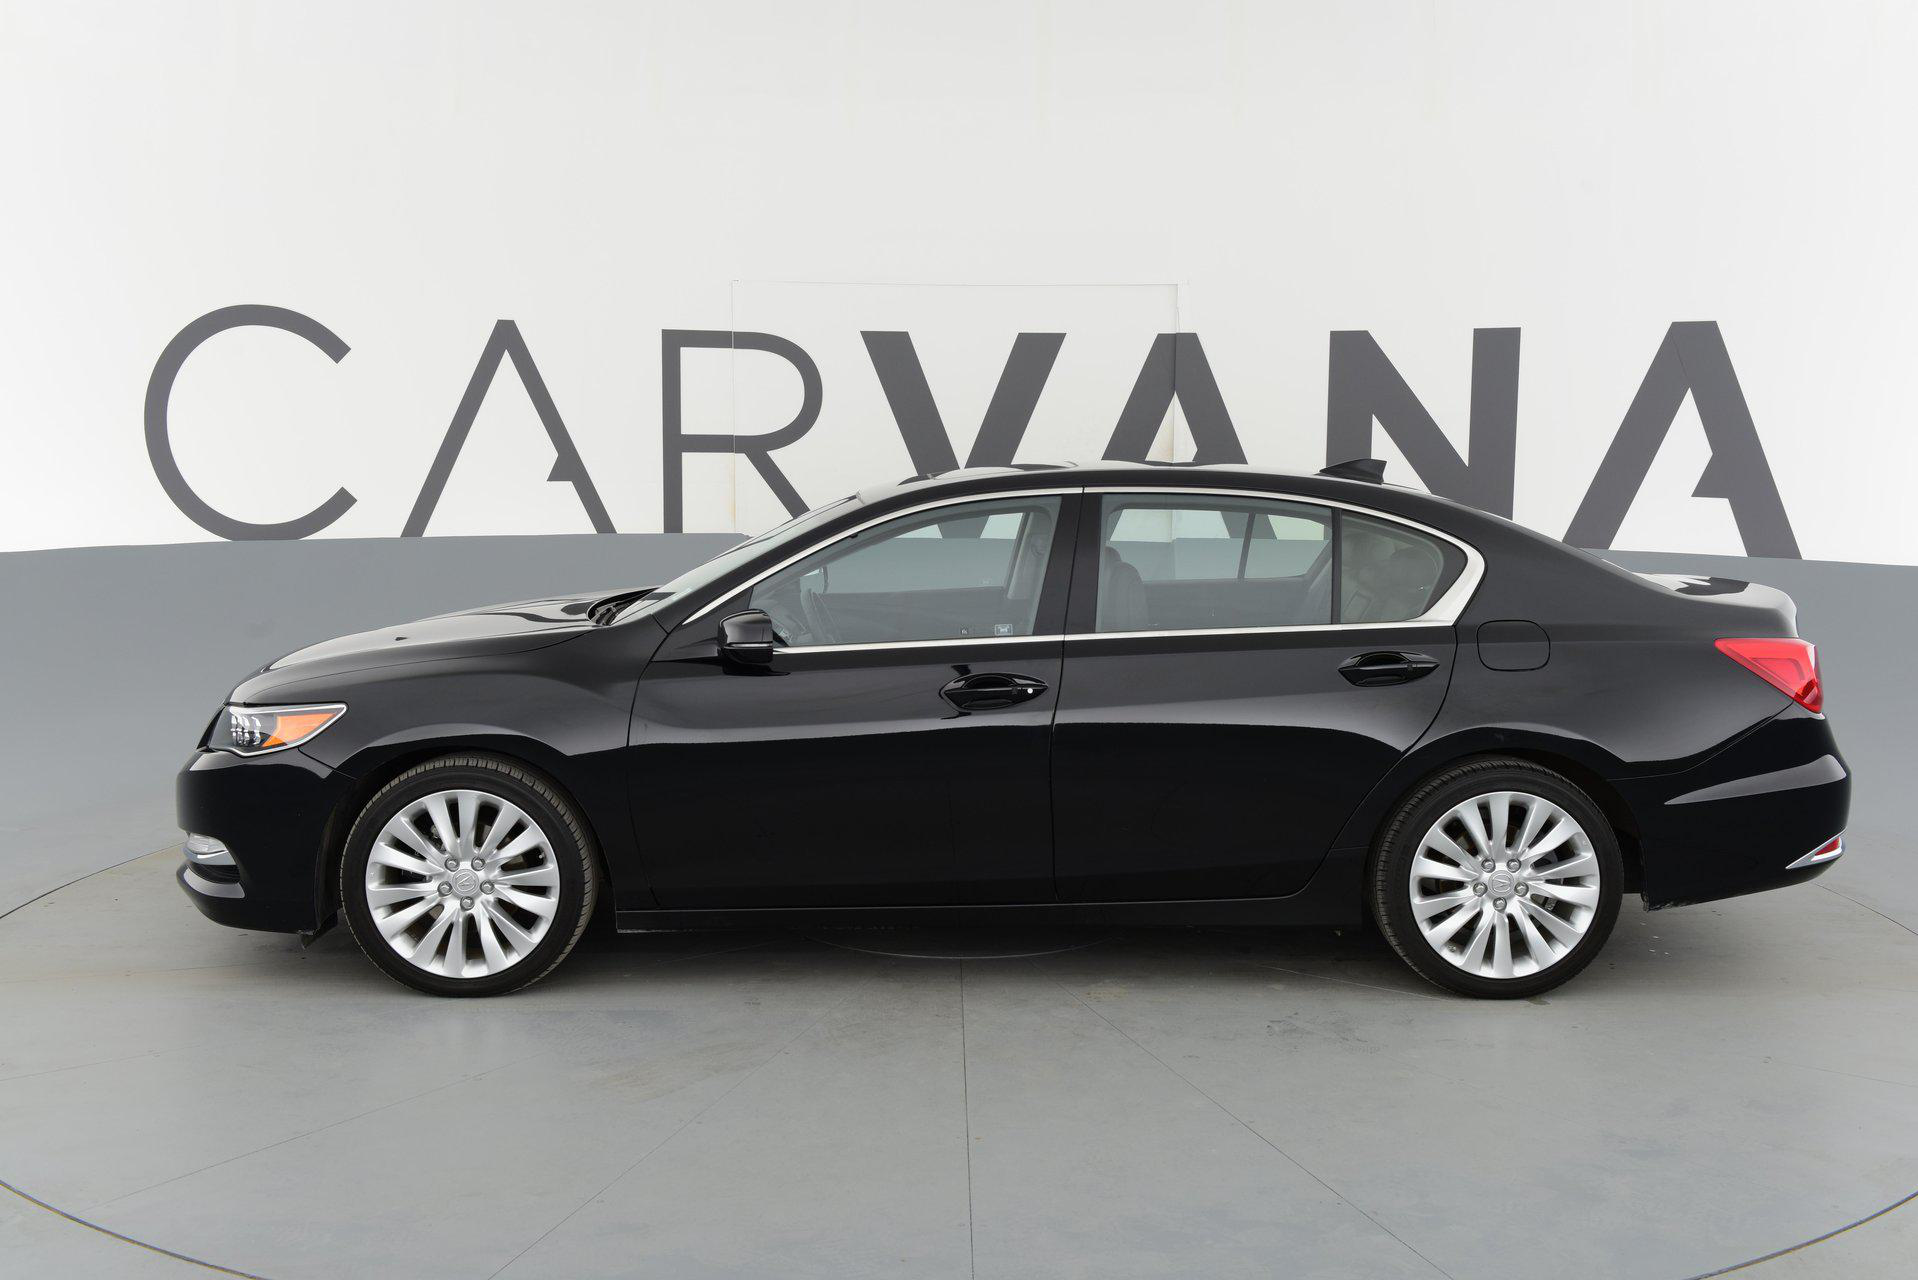

In [28]:
TF.to_pil_image(img)